In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier


/usr/local/lib/python3.10/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
# Read the CSV file into a DataFrame
# df = pd.read_csv('../data/raw/Base.csv')
df = pd.read_csv('../data/processed/undersampled_data.csv')


In [4]:
# Identify columns with string values
string_columns = df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical variables
label_encoder = LabelEncoder()
for col in string_columns:
    df[col] = label_encoder.fit_transform(df[col])
    print(col)

# Separate fraud and non-fraud data
fraud_data = df[df['fraud_bool'] == 1]
non_fraud_data = df[df['fraud_bool'] == 0]

# # Undersample non-fraud data to match the size of the fraud data
# undersampled_non_fraud_data = resample(non_fraud_data, replace=False, n_samples=len(fraud_data), random_state=42)

# # Combine fraud and undersampled non-fraud data
# combined_data = pd.concat([fraud_data, undersampled_non_fraud_data])

# Split the combined data into features (X) and target labels (y)
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



payment_type
employment_status
housing_status
source
device_os


In [5]:
import os
import pickle
from sklearn.linear_model import LogisticRegression

bm_model_path = '../data/model/bm_model.pkl'
# Check if the model file exists
if os.path.exists(bm_model_path):
    # Load the model from the file
    with open(bm_model_path, 'rb') as file:
        baseline_model = pickle.load(file)
else:
    # Train a new Logistic Regression model
    baseline_model = LogisticRegression()
    baseline_model.fit(X_train, y_train)
    # Save the trained model
    with open(bm_model_path, 'wb') as file:
        pickle.dump(baseline_model, file)

bm_pred = baseline_model.predict(X_test)
bm_roc_auc = roc_auc_score(y_test, baseline_model.predict_proba(X_test)[:,1])
fpr_bm, tpr_bm, thresholds_bm = roc_curve(y_test, baseline_model.predict_proba(X_test)[:,1])

# Evaluate the performance of the baseline_mode
accuracy = accuracy_score(y_test, bm_pred)
report = classification_report(y_test, bm_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8398514476277096
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91     11018
           1       0.59      0.10      0.17      2176

    accuracy                           0.84     13194
   macro avg       0.72      0.54      0.54     13194
weighted avg       0.80      0.84      0.79     13194



In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)


In [8]:
# Decision Tree

# Define the file path for saving/loading the model
dt_model_path = '../data/model/dt_model.pkl'

# Check if the model file exists
if os.path.exists(dt_model_path):
    # Load the model from the file
    with open(dt_model_path, 'rb') as file:
        dt_model = pickle.load(file)
else:
    # Train a new Decision Tree model
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_rfe, y_train)
    # Save the trained model
    with open(dt_model_path, 'wb') as file:
        pickle.dump(dt_model, file)

# Make predictions and compute ROC AUC
dt_pred = dt_model.predict(X_test_rfe)
dt_roc_auc = roc_auc_score(y_test, dt_model.predict_proba(X_test_rfe)[:,1])
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, dt_model.predict_proba(X_test_rfe)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, dt_pred)
report = classification_report(y_test, dt_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7810368349249659
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87     11018
           1       0.35      0.37      0.36      2176

    accuracy                           0.78     13194
   macro avg       0.61      0.62      0.61     13194
weighted avg       0.79      0.78      0.78     13194



In [9]:
# Gradient Boosting
# Define the file path for saving/loading the model
gb_model_path = '../data/model/gb_model.pkl'

# Check if the model file exists
if os.path.exists(gb_model_path):
    # Load the model from the file
    with open(gb_model_path, 'rb') as file:
        gb_model = pickle.load(file)
else:
    # Train a new Gradient Boosting model
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train_scaled, y_train)
    # Save the trained model
    with open(gb_model_path, 'wb') as file:
        pickle.dump(gb_model, file)

# Make predictions and compute ROC AUC
gb_pred = gb_model.predict(X_test_scaled)
gb_roc_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test_scaled)[:,1])
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, gb_model.predict_proba(X_test_scaled)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, gb_pred)
report = classification_report(y_test, gb_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8786569652872518
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93     11018
           1       0.72      0.43      0.54      2176

    accuracy                           0.88     13194
   macro avg       0.81      0.70      0.73     13194
weighted avg       0.87      0.88      0.87     13194



In [10]:
#XGB Model
# Define the file path for saving/loading the model
xgb_model_path = '../data/model/xgb_model.pkl'

# Check if the model file exists
if os.path.exists(xgb_model_path):
    # Load the model from the file
    with open(xgb_model_path, 'rb') as file:
        xgb_model = pickle.load(file)
else:
    # Train a new XGBoost model
    xgb_model = XGBClassifier(random_state=42)
    xgb_model.fit(X_train_scaled, y_train)
    # Save the trained model
    with open(xgb_model_path, 'wb') as file:
        pickle.dump(xgb_model, file)

# Make predictions and compute ROC AUC
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_model.predict_proba(X_test_scaled)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, xgb_pred)
report = classification_report(y_test, xgb_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8797180536607548
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93     11018
           1       0.69      0.50      0.58      2176

    accuracy                           0.88     13194
   macro avg       0.80      0.73      0.75     13194
weighted avg       0.87      0.88      0.87     13194



In [11]:
# LightGBM
# Define the file path for saving/loading the model
lgbm_model_path = '../data/model/lgbm_model.pkl'

# Check if the model file exists
if os.path.exists(lgbm_model_path):
    # Load the model from the file
    with open(lgbm_model_path, 'rb') as file:
        lgbm_model = pickle.load(file)
else:
    # Train a new LightGBM model
    lgbm_model = LGBMClassifier(random_state=42)
    lgbm_model.fit(X_train_scaled, y_train)
    # Save the trained model
    with open(lgbm_model_path, 'wb') as file:
        pickle.dump(lgbm_model, file)

# Make predictions and compute ROC AUC
lgbm_pred = lgbm_model.predict(X_test_scaled)
lgbm_roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test_scaled)[:,1])
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, lgbm_model.predict_proba(X_test_scaled)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, lgbm_pred)
report = classification_report(y_test, lgbm_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.8805517659542216
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     11018
           1       0.70      0.48      0.57      2176

    accuracy                           0.88     13194
   macro avg       0.80      0.72      0.75     13194
weighted avg       0.87      0.88      0.87     13194



In [12]:
# CatBoost
catboost_model = CatBoostClassifier(random_state=42)
catboost_model.fit(X_train_scaled, y_train)
catboost_pred = catboost_model.predict(X_test_scaled)
catboost_roc_auc = roc_auc_score(y_test, catboost_model.predict_proba(X_test_scaled)[:,1])
fpr_catboost, tpr_catboost, thresholds_catboost = roc_curve(y_test, catboost_model.predict_proba(X_test_scaled)[:,1])


Learning rate set to 0.056029
0:	learn: 0.6435950	total: 72.4ms	remaining: 1m 12s
1:	learn: 0.5997575	total: 80.1ms	remaining: 40s
2:	learn: 0.5619127	total: 88.2ms	remaining: 29.3s
3:	learn: 0.5319323	total: 96.6ms	remaining: 24s
4:	learn: 0.5045790	total: 106ms	remaining: 21.2s
5:	learn: 0.4816363	total: 116ms	remaining: 19.1s
6:	learn: 0.4608044	total: 124ms	remaining: 17.6s
7:	learn: 0.4437652	total: 132ms	remaining: 16.4s
8:	learn: 0.4277904	total: 140ms	remaining: 15.5s
9:	learn: 0.4148090	total: 149ms	remaining: 14.7s
10:	learn: 0.4031421	total: 156ms	remaining: 14s
11:	learn: 0.3936384	total: 164ms	remaining: 13.5s
12:	learn: 0.3850974	total: 170ms	remaining: 12.9s
13:	learn: 0.3762235	total: 176ms	remaining: 12.4s
14:	learn: 0.3695693	total: 183ms	remaining: 12s
15:	learn: 0.3628516	total: 189ms	remaining: 11.6s
16:	learn: 0.3569052	total: 195ms	remaining: 11.3s
17:	learn: 0.3522589	total: 200ms	remaining: 10.9s
18:	learn: 0.3477939	total: 206ms	remaining: 10.6s
19:	learn: 0.3

In [13]:
# HistGradientBoostingClassifier
hist_gb_model = HistGradientBoostingClassifier(random_state=42)
hist_gb_model.fit(X_train_scaled, y_train)
hist_gb_pred = hist_gb_model.predict(X_test_scaled)
hist_gb_roc_auc = roc_auc_score(y_test, hist_gb_model.predict_proba(X_test_scaled)[:,1])
fpr_hist_gb, tpr_hist_gb, thresholds_hist_gb = roc_curve(y_test, hist_gb_model.predict_proba(X_test_scaled)[:,1])


In [14]:
# GBDTRegressor
gbdt_regressor = GradientBoostingRegressor(random_state=42)
gbdt_regressor.fit(X_train_scaled, y_train)
gbdt_pred = gbdt_regressor.predict(X_test_scaled)


In [15]:
# adaboostClassifier
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_model.fit(X_train_scaled, y_train)
adaboost_pred = adaboost_model.predict(X_test_scaled)
adaboost_roc_auc = roc_auc_score(y_test, adaboost_model.predict_proba(X_test_scaled)[:,1])
fpr_adaboost, tpr_adaboost, thresholds_adaboost = roc_curve(y_test, adaboost_model.predict_proba(X_test_scaled)[:,1])

/usr/local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [16]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_rfe, y_train)
rf_pred = rf_model.predict(X_test_rfe)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_rfe)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_model.predict_proba(X_test_rfe)[:,1])

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.8805517659542216
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     11018
           1       0.70      0.48      0.57      2176

    accuracy                           0.88     13194
   macro avg       0.80      0.72      0.75     13194
weighted avg       0.87      0.88      0.87     13194



In [17]:
# Grid Search with Random Forest

# Define the file path for saving/loading the model
rf_grid_model_path = '../data/model/rf_grid_model.pkl'

# Check if the model file exists
if os.path.exists(rf_grid_model_path):
    # Load the model from the file
    with open(rf_grid_model_path, 'rb') as file:
        rf_grid_model = pickle.load(file)
else:
    # Define the parameter grid for grid search
    param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [None, 10, 20]}
    # Perform grid search with Random Forest
    rf_grid_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    rf_grid_model.fit(X_train_rfe, y_train)
    # Save the trained model
    with open(rf_grid_model_path, 'wb') as file:
        pickle.dump(rf_grid_model, file)

# Make predictions and compute ROC AUC
rf_grid_pred = rf_grid_model.predict(X_test_rfe)
rf_grid_roc_auc = roc_auc_score(y_test, rf_grid_model.predict_proba(X_test_rfe)[:,1])
fpr_rf_grid, tpr_rf_grid, thresholds_rf_grid = roc_curve(y_test, rf_grid_model.predict_proba(X_test_rfe)[:,1])

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, rf_grid_pred)
report = classification_report(y_test, rf_grid_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.850689707442777
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92     11018
           1       0.63      0.23      0.34      2176

    accuracy                           0.85     13194
   macro avg       0.75      0.60      0.63     13194
weighted avg       0.83      0.85      0.82     13194



2024-04-12 16:56:08.649750: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 16:56:15.063795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.il

Activation Function: relu, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.45423516631126404, Test Accuracy: 0.8346976041793823
413/413 [==============================] - 0s 887us/step
ROC AUC: 0.6516333900142014



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.4481714963912964, Test Accuracy: 0.83500075340271
413/413 [==============================] - 0s 672us/step
ROC AUC: 0.6456243393164127



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.44393765926361084, Test Accuracy: 0.8360618352890015
413/413 [==============================] - 0s 701us/step
ROC AUC: 0.5867857943685731



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.45183849334716797, Test Accuracy: 0.83500075340271
413/413 [==============================] - 0s 616us/step
ROC AUC: 0.5005833952863229



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.44776350259780884, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 638us/step
ROC AUC: 0.5



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.4477592408657074, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 683us/step
ROC AUC: 0.5



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.4479611814022064, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 704us/step
ROC AUC: 0.5



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: relu, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.44780516624450684, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 643us/step
ROC AUC: 0.5



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.43347954750061035, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 626us/step
ROC AUC: 0.6415660987234793



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.4308433532714844, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 694us/step
ROC AUC: 0.642259962474507



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.4307228624820709, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 910us/step
ROC AUC: 0.6449078688416282



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.42675840854644775, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 635us/step
ROC AUC: 0.655636406802238



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.4472954273223877, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 710us/step
ROC AUC: 0.5287460133751722



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.4472272992134094, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 620us/step
ROC AUC: 0.5111733523619104



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.44659486413002014, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 617us/step
ROC AUC: 0.558919670552465



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: sigmoid, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.44317522644996643, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 659us/step
ROC AUC: 0.5931486069252988



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.4386143088340759, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 621us/step
ROC AUC: 0.6217777493780231



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.43467989563941956, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 601us/step
ROC AUC: 0.6135773063196054



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.4388529658317566, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 613us/step
ROC AUC: 0.5990058338694435



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: adam, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.4333946406841278, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 613us/step
ROC AUC: 0.6289221831521682



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 32
Test Loss: 0.4477566182613373, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 597us/step
ROC AUC: 0.4999442548223229



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 1, Num Neurons: 64
Test Loss: 0.4468872845172882, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 637us/step
ROC AUC: 0.5300754722552935



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 32
Test Loss: 0.4478633999824524, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 646us/step
ROC AUC: 0.4981066243206304



/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Activation Function: tanh, Optimizer: sgd, Loss Function: binary_crossentropy, Num Layers: 2, Num Neurons: 64
Test Loss: 0.44861042499542236, Test Accuracy: 0.8350765705108643
413/413 [==============================] - 0s 617us/step
ROC AUC: 0.5082412352647538



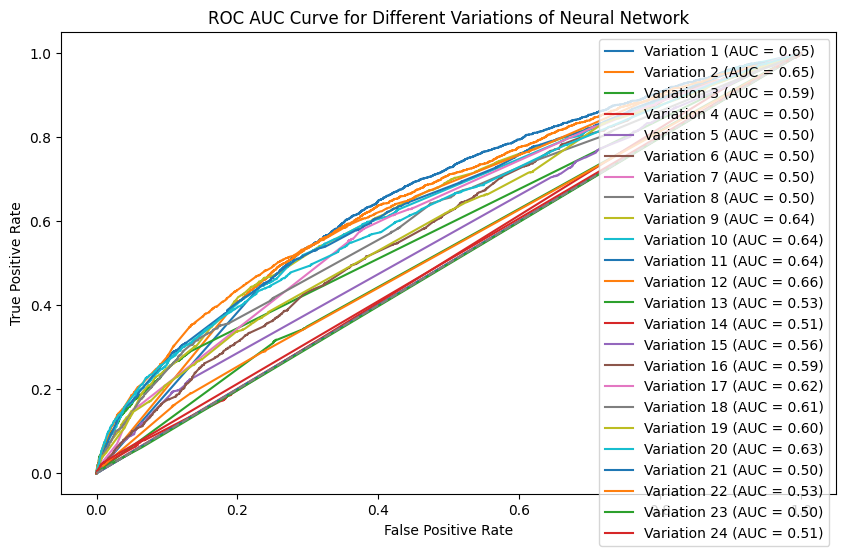

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define lists of hyperparameters to permute through
activation_functions = ['relu', 'sigmoid', 'tanh']
optimizers = ['adam', 'sgd']
loss_functions = ['binary_crossentropy']
num_layers = [1, 2]
num_neurons = [32, 64]

# Initialize lists to store ROC AUC scores and corresponding fpr, tpr, thresholds
roc_auc_scores = []
fprs = []
tprs = []
thresholdss = []

# Iterate over all permutations of hyperparameters
for activation_function in activation_functions:
    for optimizer in optimizers:
        for loss_function in loss_functions:
            for num_layer in num_layers:
                for num_neuron in num_neurons:
                    # Define the architecture of the neural network
                    nn_model = Sequential()
                    nn_model.add(Dense(num_neuron, activation=activation_function, input_shape=(X_train.shape[1],)))
                    nn_model.add(Dropout(0.5))  # Add dropout layer to prevent overfitting
                    for _ in range(num_layer - 1):
                        nn_model.add(Dense(num_neuron, activation=activation_function))
                    nn_model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation for binary classification

                    # Compile the model
                    nn_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

                    # Train the model
                    history = nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=0)

                    # Evaluate the model on test data
                    loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
                    print(f'Activation Function: {activation_function}, Optimizer: {optimizer}, Loss Function: {loss_function}, Num Layers: {num_layer}, Num Neurons: {num_neuron}')
                    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

                    # Generate predictions for test data
                    nn_pred = nn_model.predict(X_test)
                    nn_pred_proba = nn_pred.flatten()  # Flatten the predictions to get probabilities

                    # Calculate ROC AUC score
                    nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)
                    print(f'ROC AUC: {nn_roc_auc}\n')

                    # Store results
                    roc_auc_scores.append(nn_roc_auc)
                    fpr, tpr, thresholds = roc_curve(y_test, nn_pred_proba)
                    fprs.append(fpr)
                    tprs.append(tpr)
                    thresholdss.append(thresholds)

# Plot ROC AUC for all variations
plt.figure(figsize=(10, 6))
for i, roc_auc in enumerate(roc_auc_scores):
    plt.plot(fprs[i], tprs[i], label=f'Variation {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Different Variations of Neural Network')
plt.legend()
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the architecture of the neural network
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Add dropout layer to prevent overfitting
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = nn_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Generate predictions for test data
nn_pred = nn_model.predict(X_test)
nn_pred_proba = nn_pred.flatten()  # Flatten the predictions to get probabilities

# Calculate ROC AUC score
nn_roc_auc = roc_auc_score(y_test, nn_pred_proba)
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, nn_pred_proba)


Epoch 1/10


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


660/660 [==============================] - 2s 2ms/step - loss: 27.6458 - accuracy: 0.7242 - val_loss: 1.7332 - val_accuracy: 0.8227
Epoch 2/10
660/660 [==============================] - 1s 1ms/step - loss: 1.0492 - accuracy: 0.7952 - val_loss: 0.4899 - val_accuracy: 0.8266
Epoch 3/10
660/660 [==============================] - 1s 1ms/step - loss: 0.4973 - accuracy: 0.8289 - val_loss: 0.4663 - val_accuracy: 0.8315
Epoch 4/10
660/660 [==============================] - 1s 1ms/step - loss: 0.4664 - accuracy: 0.8315 - val_loss: 0.4573 - val_accuracy: 0.8314
Epoch 5/10
660/660 [==============================] - 1s 1ms/step - loss: 0.4564 - accuracy: 0.8323 - val_loss: 0.4592 - val_accuracy: 0.8321
Epoch 6/10
660/660 [==============================] - 1s 1ms/step - loss: 0.4555 - accuracy: 0.8324 - val_loss: 0.4622 - val_accuracy: 0.8318
Epoch 7/10
660/660 [==============================] - 1s 1ms/step - loss: 0.4555 - accuracy: 0.8326 - val_loss: 0.4528 - val_accuracy: 0.8318
Epoch 8/10
660/6

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=2: ROC AUC = 0.7108


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=3: ROC AUC = 0.7097


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=4: ROC AUC = 0.7097


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=5: ROC AUC = 0.7133


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=6: ROC AUC = 0.7103


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=7: ROC AUC = 0.7058


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=8: ROC AUC = 0.7134


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=9: ROC AUC = 0.7190


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


K=10: ROC AUC = 0.7116


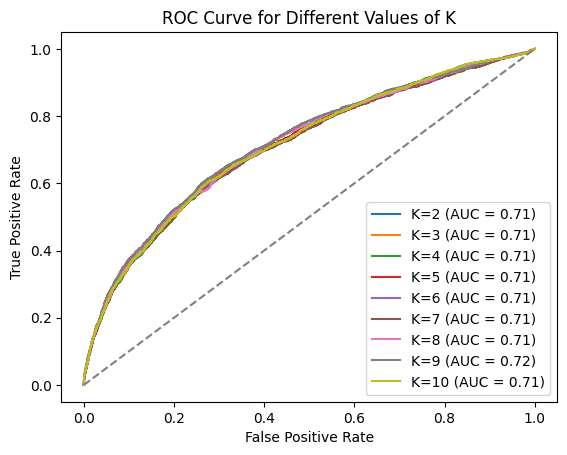

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Initialize lists to store fpr and tpr for each k
all_fpr = []
all_tpr = []

# Iterate through different values of k
for k in range(2, 11):
    # Fit KMeans clustering model
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train)
    
    # Concatenate original features with cluster labels
    X_train_clustered = np.column_stack((X_train, cluster_labels))
    
    # Train logistic regression model
    model = LogisticRegression()
    model.fit(X_train_clustered, y_train)
    
    # Transform test data using fitted clustering model
    test_cluster_labels = kmeans.predict(X_test)
    X_test_clustered = np.column_stack((X_test, test_cluster_labels))
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test_clustered)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # Append fpr and tpr to lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    
    # Calculate and print ROC AUC
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f'K={k}: ROC AUC = {roc_auc:.4f}')
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'K={k} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each k
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Values of K')
plt.legend()
plt.show()


In [21]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Feature Engineering with Clustering
# Assuming X contains your original features and y contains the target variable (fraud or not fraud)

# Fit clustering model (e.g., KMeans) to X
kmeans = KMeans(n_clusters=2)  # You can adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(X)

# Step 2: Model Training
# Concatenate original features with cluster labels
X_with_clusters = np.concatenate((X, cluster_labels.reshape(-1, 1)), axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_with_clusters, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 3: Model Evaluation
# Evaluate the model on test data
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
cluster_roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC:", roc_auc)

# Plot ROC curve
fpr_cluster, tpr_cluster, thresholds_cluster = roc_curve(y_test, y_pred_proba)


ROC AUC: 0.7116158685519951


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


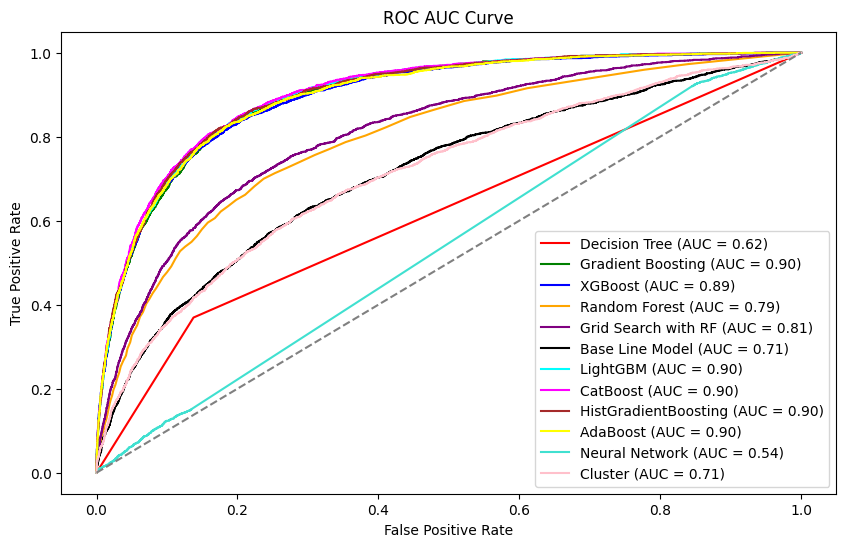

In [22]:
# Plot ROC AUC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {dt_roc_auc:.2f})', color='red')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {gb_roc_auc:.2f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_roc_auc:.2f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_roc_auc:.2f})', color='orange')
plt.plot(fpr_rf_grid, tpr_rf_grid, label=f'Grid Search with RF (AUC = {rf_grid_roc_auc:.2f})', color='purple')
plt.plot(fpr_bm, tpr_bm, label=f'Base Line Model (AUC = {bm_roc_auc:.2f})', color='black')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {lgbm_roc_auc:.2f})', color='cyan')
plt.plot(fpr_catboost, tpr_catboost, label=f'CatBoost (AUC = {catboost_roc_auc:.2f})', color='magenta')
plt.plot(fpr_hist_gb, tpr_hist_gb, label=f'HistGradientBoosting (AUC = {hist_gb_roc_auc:.2f})', color='brown')
plt.plot(fpr_adaboost, tpr_adaboost, label=f'AdaBoost (AUC = {adaboost_roc_auc:.2f})', color='yellow')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {nn_roc_auc:.2f})', color='turquoise')
plt.plot(fpr_cluster, tpr_cluster, label=f'Cluster (AUC = {cluster_roc_auc:.2f})', color='pink')


plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.show()
